# Un-Cubemapping Data

Having cubemapped data is useful if, for instance, you want to look at a specific area on the sky. This lends well to looking at a single galaxy, or a single galaxy cluster that fit entirely within one of the six faces of the cubemapped sky. However, to look at the universe as whole, it can be easier to have *all* of the data within a unified coordinate system. Maybe the easiest transformation is that from a cubemap coordinate system (e.g. Front face, X/Y coordinates) to an equirectangular coordinate system (one image, X/Y coordinates). 

With that in mind, let's get started by defining the location of our data. 

In [1]:
datapath = 'Sim Data (Clusters; 800, Seed; 2639)' # all of the data is within a folder in this .ipynb file's directory

### Cubemapped Data

In the codeblock below, I've stitched together the 6 cube face images to show how they align with each other. In the middle row, our faces are (in order): Back, Left, Front, Right.

We can see that the bottom of the Top image fits onto the top of the Left image, and the top of the Bottom image fits onto the bottom of the Left image. 

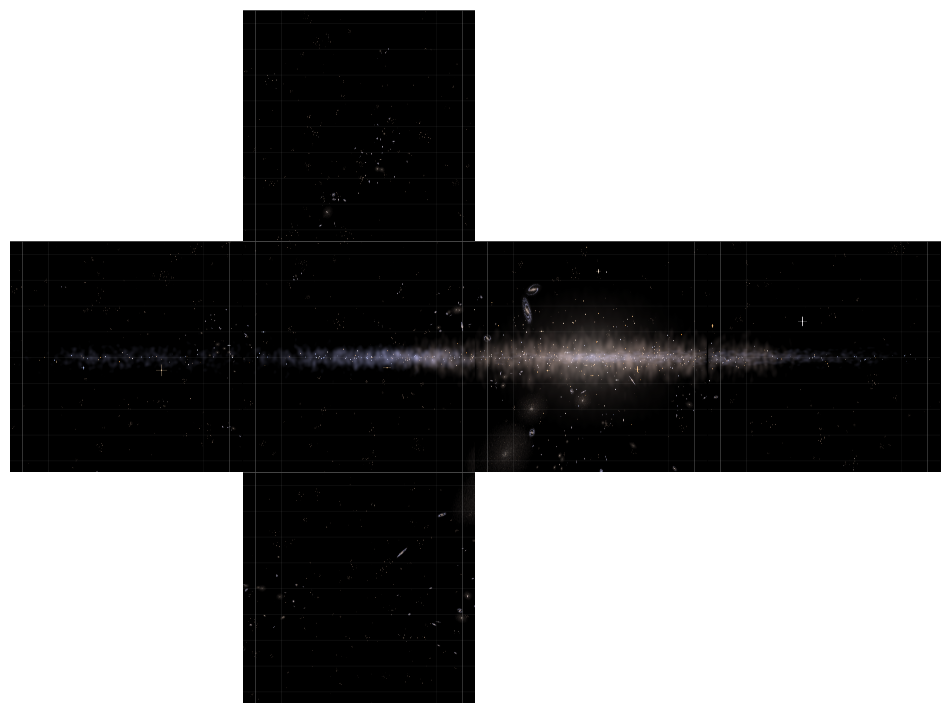

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(3, 4, figsize=(12, 9)) # generate a figure to fit 3 high by 4 wide square images
fig.subplots_adjust(wspace=0, hspace=0) # we want these squares to be adjacent to each other, with no gap
# now to iterate over each subplot and remove the axis bars and ticks/labels
for row in axes:
    for ax in row:
        for side in ['top','right','bottom','left']:
            ax.spines[side].set_visible(False)
        ax.tick_params(axis='both', which='both', labelbottom=False, bottom=False, left=False, labelleft=False)

# now we load in the images and put them at their correct location
for i, direct in enumerate(["Back", "Left", "Front", "Right", "Top", "Bottom"]): # one loop for each direction
    img = mpimg.imread(datapath + f'/{direct}/{direct}.png') # this loads in the image from the corresponding folder
    img_cropped = img[:-700, 900:] # crop the image to remove the axis labels/ticks
    if i == 4: # if the Top image
        imgplot = axes[0][1].imshow(img_cropped) # image needs to go at the top
    elif i == 5: # if the Bottom image
        imgplot = axes[2][1].imshow(img_cropped) # image needs to go at the bottom
    else:
        imgplot = axes[1][i].imshow(img_cropped) # put the image in the middle row at the correct column

Now we can start doing the coordinate transform. 

### Coordinate Transform to Equirectangular
The way we can transform from the cubemap coordinates to spherical coordinates is by doing some trigonometry, and by first identifying which portion of XYZ space our coordinates are in.
The algorithm is derived from [this wikipedia page on cubemapping](https://en.wikipedia.org/wiki/Cube_mapping), with the XYZ to spherical coordinate transfrom derived from [this wikipedia page on Spherical coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system#Cartesian_coordinates). I needed to switch around the $y$ and the $z$ in the spherical coordinate transform, because physicists and mathematicians tend not to agree on a lot of things (looking at you calculus).

In [3]:
import numpy as np
def cube_to_equirect(direction, u, v):
    # convert range -45 to 45 to -1 to 1
    uc = u / 45
    vc = v / 45
    if direction == "Front": # POSITIVE X
        x = 1
        y = vc
        z = -uc 
    elif direction == "Back":  # NEGATIVE X
        x = -1
        y = vc
        z = uc
    elif direction == "Top": # POSITIVE Y
        x = uc
        y = 1
        z = -vc
    elif direction == "Bottom": # NEGATIVE Y
        x = uc
        y = -1
        z = vc
    elif direction == "Left": # POSITIVE Z
        x = uc
        y = vc
        z = 1
    else: # direction == "Right": # NEGATIVE Z
        x = -uc
        y = vc
        z = -1 
    # now to convert the XYZ to spherical coordinates
    # this is using the physics convention of spherical coords!
    r = np.sqrt(x**2 + y**2 + z**2)
    azimuth = np.arctan2(z, x)
    theta = np.arccos(y / r)

    theta = theta * 180 / np.pi
    azimuth = (- azimuth + np.pi) * 360 / (2 * np.pi)
    
    return azimuth, theta

Now we can finally start to convert some data! To start with, let's look at the star data and plot an image of all of the resolved stars in our new unified system.

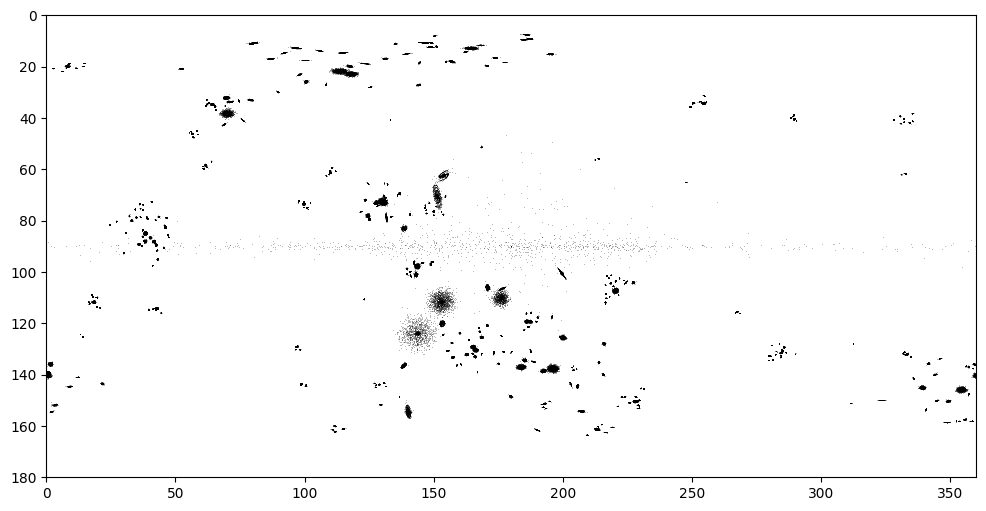

In [4]:
import pandas as pd

for i, direct in enumerate(["Front", "Back", "Left", "Right", "Top", "Bottom"]):
        # read the data from the .txt file into a dataframe
        stardata = pd.read_csv(datapath + f'/{direct}/Star Data.txt', delimiter=' ')  
        u = stardata["X"].to_numpy(); v = stardata["Y"].to_numpy() # convert X and Y data to "U" and "V" data
        azimuth, theta = cube_to_equirect(direct, u, v) # perform the coordinate transform
        azimuth = np.around(azimuth, decimals=4); theta = np.around(theta, decimals=4) # round to appropriate decimals
        
        df = pd.DataFrame({"Equat": azimuth, "Polar": theta}) # make a temporary DataFrame object with new coordinates
        # now overwrite the old coordinates with the new ones
        stardata['X'] = df['Equat']
        stardata["Y"] = df["Polar"]
        stardata = stardata.rename(columns={"X": "Equat", "Y": "Polar"}) # and finally change the name of the columns 
        if i == 0:
            # if this is the first iteration, write to a new DataFrame that will store all of the star data
            all_stardata = stardata
        else:
            all_stardata = pd.concat([all_stardata, stardata]) # add this face stardata to the rest of the data

# now let's plot the data to see if it's worked!
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(all_stardata["Equat"].to_numpy(), all_stardata["Polar"].to_numpy(), s=0.1, c='k', lw=0);
ax.set_xlim(0, 360); ax.set_ylim(0, 180);
ax.invert_yaxis();

I have it on good authority that this has worked correctly! Now to save the data to a .txt file on the system. Using `pandas`, saving a DataFrame is super easy and can be done in one line:

In [5]:
all_stardata.to_csv(datapath + "/Converted Star Data.txt", index=False, sep=' ')
# dont want to save the 'indices' of the data, and I want a space character to separate the data

Now we can repeat this process with the distant galaxy data! 

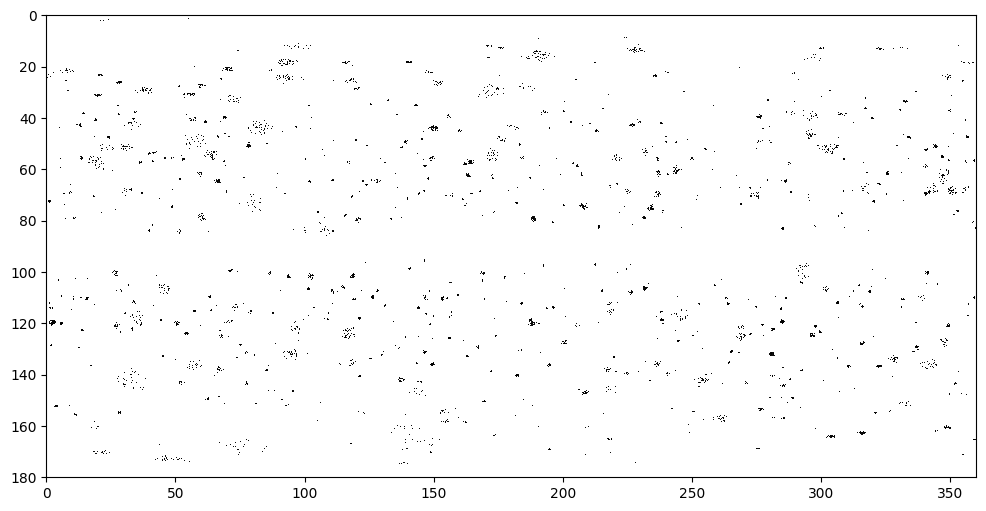

In [6]:
for i, direct in enumerate(["Front", "Back", "Left", "Right", "Top", "Bottom"]):
        # read the data from the .txt file into a dataframe
        galaxdata = pd.read_csv(datapath + f'/{direct}/Distant Galaxy Data.txt', delimiter=' ')  
        u = galaxdata["X"].to_numpy(); v = galaxdata["Y"].to_numpy() # convert X and Y data to "U" and "V" data
        azimuth, theta = cube_to_equirect(direct, u, v) # perform the coordinate transform
        azimuth = np.around(azimuth, decimals=4); theta = np.around(theta, decimals=4) # round to appropriate decimals
        
        df = pd.DataFrame({"Equat": azimuth, "Polar": theta}) # make a temporary DataFrame object with new coordinates
        # now overwrite the old coordinates with the new ones
        galaxdata['X'] = df['Equat']
        galaxdata["Y"] = df["Polar"]
        galaxdata = galaxdata.rename(columns={"X": "Equat", "Y": "Polar"}) # and finally change the name of the columns 
        if i == 0:
            # if this is the first iteration, write to a new DataFrame that will store all of the star data
            all_galaxdata = galaxdata
        else:
            all_galaxdata = pd.concat([all_galaxdata, galaxdata]) # add this face stardata to the rest of the data

# now let's plot the data to see if it's worked!
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(all_galaxdata["Equat"].to_numpy(), all_galaxdata["Polar"].to_numpy(), s=0.5, c='k', lw=0);
ax.set_xlim(0, 360); ax.set_ylim(0, 180);
ax.invert_yaxis();

Looks pretty good! We can see something going on near the horizontal middle of the image (which will be looked at in a future notebook!).

Once again, we now save this to a .txt file on disk.

In [7]:
all_galaxdata.to_csv(datapath + "/Converted Distant Galaxy Data.txt", index=False, sep=' ')
# dont want to save the 'indices' of the data, and I want a space character to separate the data

And with that we're done! With this task now done, we can more easily start looking at the actual physics within the simulation. This will be covered in the next few notebooks.